In [2]:
import $ivy.`com.stripe::rainier-core:0.3.2`
import $ivy.`com.stripe::rainier-notebook:0.3.2`

import $ivy.$                               

import $ivy.$                                   

In [3]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [4]:
PPrint.register(repl)


In [5]:
val data = {
    val franceSmoothed = List[Long](12,18,23,30,42,59,73,106,138,179,229,289,362,441,528,640,736,857,1003,1138,1282,1399,1641,1837,2053,2341,2626,2945,3163,3415,3851,4089,4231,4434,4500,4374,4230,4133,3947,3710,3708,3788,3609,3493,3603,3468,3346,3089,2895,2594,2386,2247,2052,1733,1642)
    val franceRaw = List[Long](2, 3, 21, 19, 43, 30, 48, 34, 73, 138, 190, 103, 410, 286, 372, 497, 595, 785, 838, 924, 1210, 1097, 1404, 1861, 1617, 1847, 1559, 3838, 2446, 2931, 3922, 3809, 4611, 2599, 4376, 7578, 4861, 2116, 5233, 4267, 1873, 3912, 3777, 3881, 4286, 4342, 3114, 1613, 2673, 5497, 2633, 2641, 405, 2569, 785, 2051)
    val adjacentPairs = franceSmoothed.drop(1).zip(franceSmoothed.take(franceSmoothed.size - 1))
    adjacentPairs.zipWithIndex.map{case ((kt, kt_prev), i) =>
        (i, kt_prev) -> kt
    }
}

data: List[((Int, Long), Long)] = List(
  ((0, 12L), 18L),
  ((1, 18L), 23L),
  ((2, 23L), 30L),
  ((3, 30L), 42L),
  ((4, 42L), 59L),
  ((5, 59L), 73L),
  ((6, 73L), 106L),
  ((7, 106L), 138L),
  ((8, 138L), 179L),
  ((9, 179L), 229L),
  ((10, 229L), 289L),
  ((11, 289L), 362L),
  ((12, 362L), 441L),
  ((13, 441L), 528L),
  ((14, 528L), 640L),
  ((15, 640L), 736L),
  ((16, 736L), 857L),
  ((17, 857L), 1003L),
  ((18, 1003L), 1138L),
  ((19, 1138L), 1282L),
  ((20, 1282L), 1399L),
  ((21, 1399L), 1641L),
  ((22, 1641L), 1837L),
  ((23, 1837L), 2053L),
  ((24, 2053L), 2341L),
  ((25, 2341L), 2626L),
  ((26, 2626L), 2945L),
  ((27, 2945L), 3163L),
  ((28, 3163L), 3415L),
  ((29, 3415L), 3851L),
  ((30, 3851L), 4089L),
  ((31, 4089L), 4231L),
  ((32, 4231L), 4434L),
  ((33, 4434L), 4500L),
  ((34, 4500L), 4374L),
  ((35, 4374L), 4230L),
  ((36, 4230L), 4133L),
  ((37, 4133L), 3947L),
...

Two big changes from the original model:
* run the markov process with log(R_t) to ensure that it always stays positive
* use a narrow Laplace transition to strongly regularize

In [6]:
val (model, rts) =  {
    val (xs, ys) = data.unzip

    val logR0 = Normal(0, 1).latent
    val diffs = Laplace(0,0.1).latentVec(data.size)
    val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
    val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
        val lambda = ((logRts(i).exp - 1)/7.0).exp * kt_prev
        Poisson(lambda)
    }

    (Model.observe(ys, likelihoods), logRts.map(_.exp))
}

model: Model = Model[55]
rts: Vec[Real] = Vec(
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
  Real(0.00, Infinity),
...

This seems to work best (and fastest) with a dead simple HMC(100) sampler, no mass matrix or path length adapation.

In [11]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}
val trace = model.sample(samplerConfig, 2)

Chain 1 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.96 E-BFMI: 0.82 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 8s

Chain 2 Complete : Iteration: 1000 (4ms) Acceptance rate: 0.86 E-BFMI: 0.82 Step size: 0.02 Total gradient evaluations: 2e+05 (19us) Total time: 8s

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd10$Helper$$anon$1@4f517dad
trace: Trace = Trace[2][1000][55]

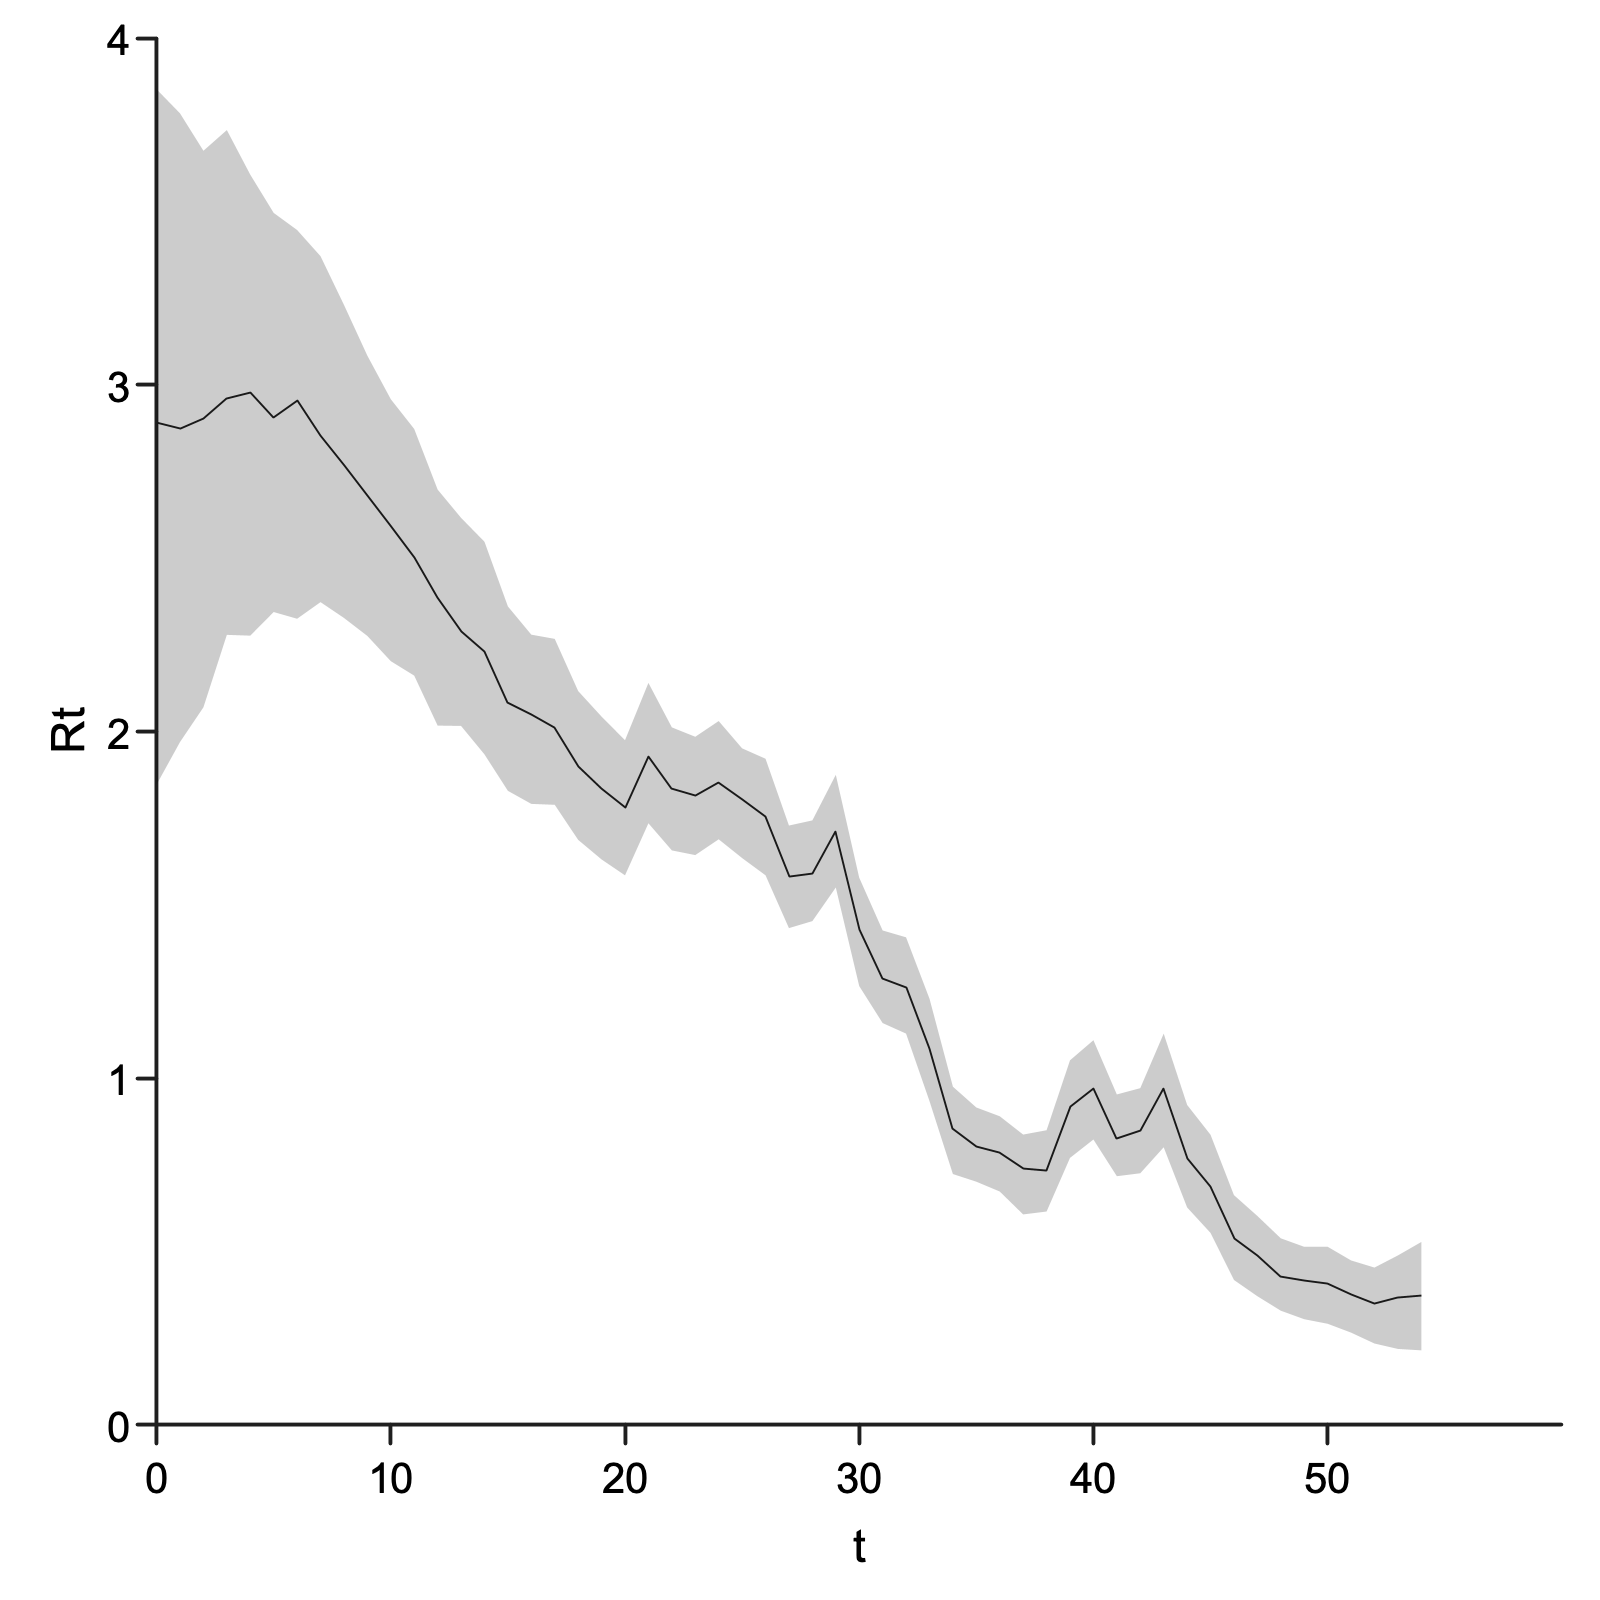

In [12]:
{{
    val rtForecasts = trace.predict(rts)
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    show("t", "Rt", line(means), shade(hdpis))
}}